In [ ]:
!pip install langgraph langchain langchain_openai langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.1 MB/s eta 0:00:00


# Simple sequential workflow

In [ ]:
from langgraph.graph import StateGraph ,END , START
from typing import TypedDict

In [ ]:
# define the state class
class BMIState(TypedDict):
  height: float
  weight: float
  bmi: float
  category : str

In [ ]:
# define graph

graph = StateGraph(BMIState) # graph object is of the stategraph

In [ ]:
# define the node function
def bmi_calculator (state : BMIState) -> BMIState : # input graph state and aslo after the execution it retrns the state
  weight = state['weight']
  height = state['height']

  bmi = weight / (height**2)

  state['bmi'] = round(bmi,2)

  return state

In [ ]:
def label_bmi (state : BMIState) -> BMIState :
  bmi = state['bmi']

  if bmi < 18.5 :
    state['category'] = 'Underweight'
  elif bmi >= 18.5 and bmi < 25 :
    state['category'] = 'Normal'
  elif bmi >= 25 and bmi < 30 :
    state['category'] = 'Overweight'
  else :
    state['category'] = 'Obese'

  return state



In [ ]:

graph.add_node("calculate_bmi" , bmi_calculator)
graph.add_node("category_bmi" , label_bmi)

graph.add_edge(START,"calculate_bmi")
graph.add_edge("calculate_bmi", "category_bmi")
graph.add_edge("category_bmi",END)


workflow = graph.compile()

In [ ]:
final_state = workflow.invoke({'weight':67.5 , 'height': 1.78}) # these values will be assigined to the state

In [ ]:
print(final_state)

{'height': 1.78, 'weight': 67.5, 'bmi': 21.3, 'category': 'Normal'}


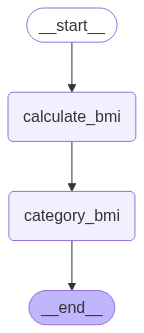

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

# Simple LLM Workflow

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph ,END , START
from typing import TypedDict


In [ ]:
llm_model = ChatOpenAI(model_name="gpt-3.5-turbo")

In [ ]:
llm_model.invoke('hi').content

'Hello! How can I assist you today?'

In [ ]:
class llm_state (TypedDict) :
  question : str
  answer : str

In [ ]:
graph = StateGraph(llm_state)

In [ ]:
def llm_qa(state : llm_state) -> llm_state :
  question = state['question']

  # form a prompt
  prompt = f"Answer the following question {question}"

  # ask the question to the LLM
  result = llm_model.invoke(prompt)

  # update the answer
  state['answer'] = result

  return state

In [ ]:
# add nodes
graph.add_node("llm_qa" , llm_qa)

# add edges
graph.add_edge(START , "llm_qa")
graph.add_edge("llm_qa", END)

# compile
workflow = graph.compile()

In [ ]:
rslt = workflow.invoke({'question':'famous quote consist of three words'})

In [ ]:
rslt['answer'].content

'"Live, laugh, love."'

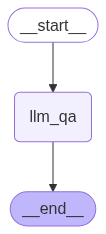

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

# Prompt Chaining

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph ,END , START
from typing import TypedDict


In [ ]:
class llm_state (TypedDict) :
  topic : str
  outline : str
  blog  : str

In [ ]:
graph = StateGraph(llm_state)

In [ ]:
def generate_outline (state : llm_state) -> llm_state :
  Topic = state['topic']

  prompt = f"Generate the outline in the bullet points on the given topic : {Topic} "

  result = llm_model.invoke(prompt)

  state['outline'] = result

  return state

In [ ]:
def generate_content (state : llm_state) -> llm_state :
  title = state['topic']
  outline_content = state['outline'].content

  prompt = f"Generate the blog on the given title {title} on the basis of the provided outlitne : \n {outline_content} "

  result = llm_model.invoke(prompt)

  state['blog'] = result

  return state

In [ ]:
graph.add_node('generate_outline' , generate_outline)
graph.add_node('generate_content' , generate_content)

grap = graph.add_edge(START , 'generate_outline')
graph.add_edge('generate_outline' , 'generate_content')
graph.add_edge('generate_content' , END)

workflow = graph.compile()

In [ ]:
final_state = workflow.invoke({'topic' : 'Machine Learning'})

In [ ]:
print(final_state)

{'topic': 'Machine Learning', 'outline': AIMessage(content='- Introduction to Machine Learning\n    - Definition of Machine Learning\n    - Importance of Machine Learning in various industries\n- Types of Machine Learning\n    - Supervised Learning\n    - Unsupervised Learning\n    - Reinforcement Learning\n- Machine Learning Algorithms\n    - Decision Trees\n    - Support Vector Machines\n    - Neural Networks\n- Applications of Machine Learning\n    - Healthcare\n    - Finance\n    - Autonomous vehicles\n- Challenges and limitations of Machine Learning\n    - Data availability and quality\n    - Bias in algorithms\n    - Interpretability of results\n- Future trends in Machine Learning\n    - Deep Learning\n    - Explainable AI\n    - Federated Learning\n- Conclusion\n    - Recap of the main points discussed\n    - Potential impact of Machine Learning on society', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 161, 'prompt_tokens': 22, 'to

In [ ]:
print(final_state['blog'].content)

Machine Learning: Transforming Industries with Data and Algorithms

Introduction to Machine Learning

Machine Learning is a subset of artificial intelligence that enables machines to learn from data without being explicitly programmed. It allows computers to identify patterns, make decisions, and improve their performance over time. The importance of Machine Learning in various industries cannot be overstated, as it has the potential to revolutionize processes and drive innovation.

Types of Machine Learning

There are three main types of Machine Learning: Supervised learning, Unsupervised learning, and Reinforcement learning. Supervised learning involves training a model on labeled data, while Unsupervised learning finds patterns in unlabeled data. Reinforcement learning uses trial and error to learn optimal behaviors.

Machine Learning Algorithms

There are several Machine Learning algorithms used to analyze data and make predictions. Decision Trees, Support Vector Machines, and Neur

In [ ]:
print(final_state['outline'].content)

- Introduction to Machine Learning
    - Definition of Machine Learning
    - Importance of Machine Learning in various industries
- Types of Machine Learning
    - Supervised Learning
    - Unsupervised Learning
    - Reinforcement Learning
- Machine Learning Algorithms
    - Decision Trees
    - Support Vector Machines
    - Neural Networks
- Applications of Machine Learning
    - Healthcare
    - Finance
    - Autonomous vehicles
- Challenges and limitations of Machine Learning
    - Data availability and quality
    - Bias in algorithms
    - Interpretability of results
- Future trends in Machine Learning
    - Deep Learning
    - Explainable AI
    - Federated Learning
- Conclusion
    - Recap of the main points discussed
    - Potential impact of Machine Learning on society
